In [ ]:
# https://stackoverflow.com/questions/76222239/pip-install-gymnasiumbox2d-not-working-on-google-colab
!pip install swig
!pip install gymnasium[box2d]

In [ ]:
import random
import numpy as np
import torch
import time
import torch.nn as nn
import os
import gymnasium as gym
import torch.nn.functional as F
from collections import deque
from gymnasium import wrappers

In [ ]:
class ExperienceReplay:

  def __init__(self, capacity: int):
    self.storage = []
    self.max_size = capacity

  def add(self, transition):
    if len(self.storage) == self.max_size:
      self.storage[int(self.ptr)] = transition
      self.ptr = (self.ptr + 1) % self.max_size
    else: self.storage.append(transition)

  def sample(self, batch_size):
    ind = np.random.randint(0, len(self.storage), size=batch_size)
    batch_states, batch_next_states, batch_actions, batch_rewards, batch_dones = [], [], [], [], []
    for i in ind:
      state, next_state, action, reward, done = self.storage[i]
      batch_states.append(np.array(state, copy=False))
      batch_next_states.append(np.array(next_state, copy=False))
      batch_actions.append(np.array(action, copy=False))
      batch_rewards.append(np.array(reward, copy=False))
      batch_dones.append(np.array(done, copy=False))
    return np.array(batch_states), np.array(batch_next_states), np.array(batch_actions), np.array(batch_rewards).reshape(-1, 1), np.array(batch_dones).reshape(-1, 1)

In [ ]:
class ActorNetwork(nn.Module):

  def __init__(self, num_states: int, num_actions: int, max_actions):
    super().__init__()
    self.layer_1 = nn.Linear(num_states, 400)
    self.layer_2 = nn.Linear(400, 300)
    self.layer_3 = nn.Linear(300, num_actions)
    self.max_actions = max_actions

  def forward(self, x):
    x = F.relu(self.layer_1(x))
    x = F.relu(self.layer_2(x))
    x = self.max_actions * torch.tanh(self.layer_3(x))
    return x

In [ ]:
class CriticNetwork(nn.Module):

  def __init__(self, num_states: int, num_actions: int):
    super().__init__()
    # First Critic Model
    self.layer_1 = nn.Linear(num_states + num_actions, 400)
    self.layer_2 = nn.Linear(400, 300)
    self.layer_3 = nn.Linear(300, 1)
    # Second Critic Model
    self.layer_4 = nn.Linear(num_states + num_actions, 400)
    self.layer_5 = nn.Linear(400, 300)
    self.layer_6 = nn.Linear(300, 1)

  def forward(self, x, u) -> tuple:
    xu = torch.cat([x, u], 1)
    # first critic Q value
    x1 = F.relu(self.layer_1(xu))
    x1 = F.relu(self.layer_2(x1))
    q1 = self.layer_3(x1)
    # second critic Q value
    x2 = F.relu(self.layer_4(xu))
    x2 = F.relu(self.layer_5(x2))
    q2 = self.layer_6(x2)
    return q1, q2

  def Q1(self, x, u):
    # Used for backpropogating Actor Model weights with gradient **ascent**
    xu = torch.cat([x, u], 1)
    x = F.relu(self.layer_1(xu))
    x = F.relu(self.layer_2(x))
    return self.layer_3(x)



In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("You are on device", device)

You are on device cuda


In [ ]:
class TD3:

  def __init__(self, num_states: int, num_actions: int, max_actions):
    self.max_action = max_actions
    # Actor Model
    self.actor = ActorNetwork(num_states, num_actions, max_actions).to(device)
    # Actor Target
    self.actor_target = ActorNetwork(num_states, num_actions, max_actions).to(device)
    # Actor target should have same weights and biases as actor model
    self.actor_target.load_state_dict(self.actor.state_dict())
    # Actor Optimizer
    self.actor_optimizer = torch.optim.Adam(self.actor.parameters())

    # Critic Model
    self.critic = CriticNetwork(num_states, num_actions).to(device)
    # Critic Target
    self.critic_target = CriticNetwork(num_states, num_actions).to(device)
    # Critic target should have same weights and biases as critic model
    self.critic_target.load_state_dict(self.critic.state_dict())
    # Critic Optimizer
    self.critic_optimizer = torch.optim.Adam(self.critic.parameters())

  def select_action(self, state):
    state = torch.Tensor(state.reshape(1, -1)).to(device)
    return self.actor(state).cpu().data.numpy().flatten()

  def train(self, replay_buffer, iteration, batch_size=100, discount=0.99, tau=0.005, policy_noise=0.2, noise_clip=0.5, policy_freq=2):

    for it in range(iteration):
      batch_states, batch_next_states, batch_actions, batch_rewards, batch_dones = replay_buffer.sample(batch_size)
      state = torch.Tensor(batch_states).to(device)
      next_state = torch.Tensor(batch_next_states).to(device)
      action = torch.Tensor(batch_actions).to(device)
      reward = torch.Tensor(batch_rewards).to(device)
      done = torch.Tensor(batch_dones).to(device)

      # From the next state s', the actor target plays the next action a'
      next_action = self.actor_target(next_state)
      # Add Gaussian noise to this action a' and we clamp the noise and action with noise_clip and max_Action
      noise = torch.Tensor(batch_actions).data.normal_(0, policy_noise).to(device)
      noise = noise.clamp(-noise_clip, noise_clip)
      next_action = (next_action + noise).clamp(-self.max_action, self.max_action)

      # get target critic q values for given state and action
      target_Q1, target_Q2 = self.critic_target(next_state, next_action)
      # keep the minimum of two: TODO: why?
      target_Q = torch.min(target_Q1, target_Q2)

      # with torch.no_grad:
      #   # target Q value = reward + discount * target_Q
      #   target_Q = reward + ((1 - done) * discount * target_Q)
      target_Q = reward + ((1 - done) * discount * target_Q).detach()
      # Get current Q estimates
      current_Q1, current_Q2 = self.critic(state, action)
      # compute the MSE loss for current_q(s) with target q
      critic_loss = F.mse_loss(current_Q1, target_Q) + F.mse_loss(current_Q2, target_Q)

      # Optimize the critic (this will update the wieghts of critic model not critic target, as optim points to model)
      self.critic_optimizer.zero_grad()
      critic_loss.backward()
      self.critic_optimizer.step()

      if it % policy_freq == 0:
        # This is the Policy Gradient part where we want to achieve gradient **Ascend** hence the negative sign
        # adap optimizer will compute the gradient with Q1 value of critic for a given actor's action at a particular
        # state
        actor_loss = -self.critic.Q1(state, self.actor(state)).mean()
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
          target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

        for param, target_param in zip(self.critic.parameters(), self.critic_target.parameters()):
          target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

  def save(self, filename, directory):
    torch.save(self.actor.state_dict(), '%s/%s_actor.pth' % (directory, filename))
    torch.save(self.critic.state_dict(), '%s/%s_critic.pth' % (directory, filename))

  def load(self, filename, directory):
    self.actor.load_state_dict(torch.load('%s/%s_actor.pth' % (directory, filename)))
    self.critic.load_state_dict(torch.load('%s/%s_critic.pth' % (directory, filename)))


In [ ]:
def evaluate_policy(policy, env, eval_episodes=10, video=None):
  avg_reward=0.
  for _ in range(eval_episodes):
    obs, info = env.reset()
    done = False
    while not done:
      if video is not None:
        env.render()
        video.capture_frame()
      action = policy.select_action(np.array(obs))
      obs, reward, terminated, truncated, _ = env.step(action)
      done = terminated or truncated
      avg_reward += reward
  avg_reward /= eval_episodes
  print ("---------------------------------------")
  print(f'Average Reward for the Evaluation step : {avg_reward}')
  print ("---------------------------------------")
  return avg_reward

In [ ]:
env_name = "BipedalWalker-v3"
seed = 0
start_timesteps = 1e4 # do exploration for first 10,000 steps
eval_freq = 5e3 # evaluate after every 5000 v
max_timesteps = 5e5 # maximum 500,000 steps
save_model = True
expl_noise = 0.1 # noise for action
batch_size = 100 # sample size to be taken for training
discount = 0.99 # discount factor for critic target model
tau = 0.005 # how much should actor target adopt from actor model
policy_noise = 0.2 # policy noise
noise_clip = 0.5 # noise for action-dash from action target model
policy_freq = 2 # how frequently actor model should be backpropogated

In [ ]:
file_name = '%s_%s_%s' % ('TD3', env_name, str(seed))
print ("---------------------------------------")
print(f'Setting : {file_name}')
print ("---------------------------------------")

---------------------------------------
Setting : TD3_BipedalWalker-v3_0
---------------------------------------


In [ ]:
if not os.path.exists('./results'):
  os.makedirs('./results')
if save_model and not os.path.exists('./pytorch_models'):
  os.makedirs('./pytorch_models')

In [ ]:
env = gym.make(env_name)

In [ ]:
# env.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
max_action = float(env.action_space.high[0])

In [ ]:
policy = TD3(state_dim, action_dim, max_action)
replay_buffer = ExperienceReplay(1_000_000)

In [ ]:
evaluations = [evaluate_policy(policy, env)]

---------------------------------------
Average Reward for the Evaluation step : -118.40495225249246
---------------------------------------


In [ ]:
def mkdir(base, name):
  path = os.path.join(base, name)
  if not os.path.exists(path): os.makedirs(path)
  return path
work_dir = mkdir('exp', 'brs')
monitor_dir = mkdir(work_dir, 'monitor')
max_episode_steps = env._max_episode_steps
save_env_vid = False
if save_env_vid:
  env = wrappers.Monitor(env, monitor_dir, force=True)
  env.reset()

In [ ]:
total_timesteps = 0
timesteps_since_eval = 0
episode_num = 0
done = True
t0 = time.time()

In [ ]:
while total_timesteps < max_timesteps:

  if done:

    if total_timesteps != 0:
      print("Total Timesteps: {} Episode Num: {} Reward: {}".format(total_timesteps, episode_num, episode_reward))
      policy.train(replay_buffer, episode_timesteps, batch_size, discount, tau, policy_noise, noise_clip, policy_freq)

    if timesteps_since_eval > eval_freq:
      timesteps_since_eval %= eval_freq
      evaluations.append(evaluate_policy(policy, env))
      policy.save(file_name, './pytorch_models')
      np.save('./results/%s' % (file_name), evaluations)

    obs, info = env.reset()
    done = False
    episode_reward = 0
    episode_timesteps = 0
    episode_num += 1

  if total_timesteps < start_timesteps:
    action = env.action_space.sample()
  else:
    action = policy.select_action(obs)
    if expl_noise != 0:
      action = (action + np.random.normal(0, expl_noise, size=env.action_space.shape[0])).clip(env.action_space.low, env.action_space.high)

  new_obs, reward, terminated, truncated, _ = env.step(action)
  done = terminated or truncated

  episode_reward += reward

  replay_buffer.add((obs, new_obs, action, reward, terminated))

  obs = new_obs
  episode_timesteps += 1
  total_timesteps += 1
  timesteps_since_eval += 1

evaluations.append(evaluate_policy(policy, env))
if save_model: policy.save(file_name, './pytorch_models')
np.save('./results/%s' % (file_name), evaluations)

Total Timesteps: 1600 Episode Num: 1 Reward: -85.76036759523107
Total Timesteps: 1731 Episode Num: 2 Reward: -101.54166693876032
Total Timesteps: 3331 Episode Num: 3 Reward: -89.5469451325826
Total Timesteps: 4931 Episode Num: 4 Reward: -79.97360990984306
Total Timesteps: 4983 Episode Num: 5 Reward: -110.46051908934753
Total Timesteps: 5033 Episode Num: 6 Reward: -110.26138110424579
---------------------------------------
Average Reward for the Evaluation step : -116.09342524599683
---------------------------------------
Total Timesteps: 5091 Episode Num: 7 Reward: -99.91450871464936
Total Timesteps: 5208 Episode Num: 8 Reward: -119.62163650367843
Total Timesteps: 5322 Episode Num: 9 Reward: -102.79938224739007
Total Timesteps: 6922 Episode Num: 10 Reward: -76.8863981486354
Total Timesteps: 7033 Episode Num: 11 Reward: -99.21210549837103
Total Timesteps: 7096 Episode Num: 12 Reward: -115.74798593374916
Total Timesteps: 7174 Episode Num: 13 Reward: -99.14636902857323
Total Timesteps: 72

In [ ]:
import pickle
with open("train_eval.pkl", "wb") as f:
  pickle.dump(evaluations, f)

/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment BipedalWalker-v3 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


In [ ]:
import os
os.getcwd()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'/content'

In [ ]:
eval_episodes = 10
tmp_env = gym.make(env_name, render_mode="rgb_array")

from gym.wrappers import RecordVideo
inference = "inference.mp4"
env = RecordVideo(tmp_env, "video")
obs, info = env.reset()
env.start_video_recorder()

# max_episode_steps = env._max_episode_steps

save_env_vid = True
# if save_env_vid:
#   env = wrappers.Monitor(env, monitor_dir, force=True)
#   env.reset()
# env.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
max_action = float(env.action_space.high[0])
policy = TD3(state_dim, action_dim, max_action)
policy.load(file_name, './pytorch_models/')
# _ = evaluate_policy(policy, env, eval_episodes=eval_episodes, video=video)

avg_reward=0.
for _ in range(eval_episodes):
  obs, info = env.reset()
  done = False
  while not done:
    # if video is not None:
    env.render()
      # video.capture_frame()
    action = policy.select_action(np.array(obs))
    obs, reward, done, _ = env.step(action)
    # done = terminated or truncated
    avg_reward += reward
avg_reward /= eval_episodes

env.close_video_recorder()

# Close the environment
env.close()
print ("---------------------------------------")
print(f'Average Reward for the Evaluation step : {avg_reward}')
print ("---------------------------------------")


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/record_video.py:78: UserWarning: WARN: Overwriting existing videos at /content/video folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gymnasium/core.py:311: UserWarning: WARN: env.is_vector_env to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.is_vector_env` for environment variables or `env.get_wrapper_attr('is_vector_env')` that will search the reminding wrappers.
  logger.warn(


---------------------------------------
Average Reward for the Evaluation step : 259.5779376588547
---------------------------------------


In [ ]:
import matplotlib.pyplot as plt

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


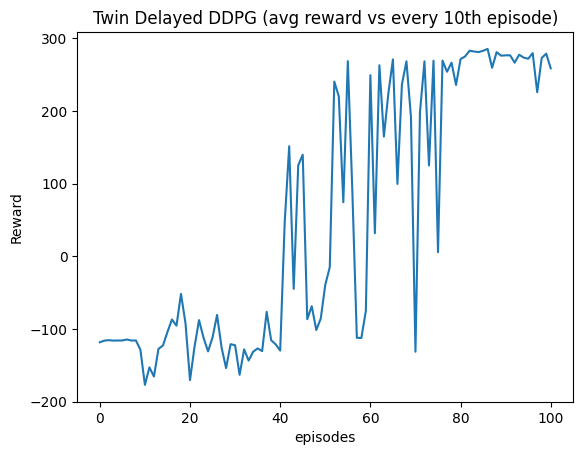

In [ ]:
%matplotlib inline
plt.plot(evaluations)
plt.title("Twin Delayed DDPG (avg reward vs every 10th episode)")
plt.xlabel("episodes")
plt.ylabel("Reward")
plt.show()